# Attempt to DataClean - Claude

In [83]:
#import required modules:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.cm as cm


#for the "heavy" work:
from dateutil.parser import parse
import matplotlib as mpl
from matplotlib.pylab import rcParams

import seaborn as sns
#import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.tsa.arima_model import ARIMA

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


In [84]:
df_aegeri = pd.read_csv("./data/output/aegeri_matchup_skin_meteo.csv")
df_aegeri.rename(columns={"skin_datetime": "datetime"}, inplace=True)
df_aegeri.head()

,x,y,y1,air_temp,wind_speed,air_pressure,rel_humidity,sol_irr,meteo_timestamp,datetime,meteo_datetime
0,1673827212,3.02,5.4126,0.097986,1.205708,923.490000,96.518056,0.005556,1.673827e+09,2023-01-16 01:00:12,2023-01-16 01:00:01.299
1,1673827812,2.31,5.4280,0.088542,0.839819,923.182361,96.376389,0.000000,1.673828e+09,2023-01-16 01:10:12,2023-01-16 01:10:01.227
2,1673828412,1.42,5.3449,0.014833,1.662911,923.037778,93.963889,0.000000,1.673828e+09,2023-01-16 01:20:12,2023-01-16 01:20:01.248
3,1673829012,2.23,5.3823,-0.130850,1.512694,922.666095,92.789760,0.000000,1.673829e+09,2023-01-16 01:30:12,2023-01-16 01:30:01.267
4,1673829612,1.30,5.3983,-0.134694,1.374958,922.583611,92.837500,0.000000,1.673830e+09,2023-01-16 01:40:12,2023-01-16 01:40:01.285


In [85]:
df_aegeri["datetime"]=pd.to_datetime(df_aegeri["datetime"])

## 1.1 plot the data

In [86]:
df_aegeri.index=df_aegeri["datetime"]

In [87]:
#plt.plot(df_aegeri["y"])

### Good, the csv loaded correctly: Now to reduplicate all the following stept, I think it is the best if we make a Class in order to throw all the generated csv at. It is important that the structure of the csv is not changing.

In [88]:
class Data:
    def __init__(self,path,name):
        self.path=path
        self.name=name
        self.dataframe=pd.read_csv(path)
        self.columns=self.dataframe.columns
        #convert the strings and add the datetime column to index
        self.dataframe["datetime"]=pd.to_datetime(self.dataframe["datetime"])
        self.dataframe.index=self.dataframe["x"]
        self.dataframe=self.dataframe.drop(columns=["x"])


    def __repr__(self):
        return f"DataFrame {name} with columns: {str(list(self.columns))}"

    def calc_rolling_statistics(self,column,window,statistics,plot="no",save_plot="no"):
        mean_rm = self.dataframe[column].rolling(window=window).mean()
        std_rm = self.dataframe[column].rolling(window=window).std()


        if print != "no":
            plt.style.context
            plt.figure(figsize=(20,10))
            actual=plt.plot(self.dataframe["datetime"],self.dataframe[column], color='red', label='Actual',alpha=0.7)
            mean_rm=plt.plot(self.dataframe["datetime"],mean_rm, color='green', label=f'Rolling Mean (window: {window})',alpha=0.7)
            std_rm=plt.plot(self.dataframe["datetime"],std_rm, color='black', label=f'Rolling Std (window: {window})',alpha=0.7)
            plt.legend(loc='best')
            plt.title('Rolling Mean & Standard Deviation')
            if save_plot =="yes":
                plt.savefig(f"./data/output_png/{input('How should the figure be named? (no Spaces!)')}.png")
            elif save_plot != "no":
                plt.savefig(f"./data/output_png/{save_plot}.png")

            plt.show(block=False)

    def check_stationarity(self,column):
        print(f"Visual check is advised with {self.name}.calc_rolling_statsitics(...,plot='Y')")
        print("->  A stationary Time Series is one which characteristics like mean and variance does not change over time.")
        print("Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:")
        print("--------------------")
        print('Dickey-Fuller Test: ')
        X = self.dataframe[column].dropna().values
        dftest=adfuller(X, autolag='AIC')
        dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value

        if list(dfoutput.items())[1][1] > 0.05:
            print(f"with a p-value of {round(list(dfoutput.items())[1][1],3)}, we fail to reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return False
        else:
            print(f"with a p-value of {round(list(dfoutput.items())[1][1],3)}, we reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return True


    def AutoRegressiveModel(self,column): #source/idea: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
        print("The Auto-Regressive (AR) model assumes that the current value (y_t) is dependent on previous values (y_(t-1), y_(t-2), …). Because of this assumption, we can build a linear regression model.\nTo figure out the order of an AR model, you need to look at the PACF:\n------------------------------------------------------------------------------")

        lag_pacf=pacf(self.dataframe[column], nlags=10, method='ols')

        plt.subplot()
        plt.plot(self.dataframe["datetime"],lag_pacf)
        plt.axhline(y=0,linestyle='--',color='green')
        plt.axhline(y=-1.96/np.sqrt(len(self.dataframe[column])),linestyle='--',color='green')
        plt.axhline(y=1.96/np.sqrt(len(self.dataframe[column])),linestyle='--',color='green')
        plt.title('Partial Autocorrelation Function')

    def AutocorrelationModel(self,column):
        plot_acf(self.dataframe[column],lags=10)


    def activate_testingmodus(self):
        self.dataframe=self.dataframe[1:100]

    def detect_outlier(self,column): #deprechiated, see detect_outlier2(self)
        print("DETECT_OUTLIERS(): Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. (source: University of Pennsylvania) ")

        if column=="all":
            sns.boxplot(data=self.dataframe)
            plt.title("Boxplot of the whole dataset")
            plt.show()
        else:
            sns.boxplot(data=self.dataframe[["datetime",column]])
            plt.title(f"Boxplot of the column {column}")
            plt.xlabel(f"{column}")
            plt.show()

            q1=self.dataframe[column].quantile(0.25)
            q3=self.dataframe[column].quantile(0.75)
            IQR=q3-q1
            outliers=self.dataframe[["datetime",column]][((self.dataframe[column]<(q1-1.5*IQR)) | (self.dataframe[column]>(q3+1.5*IQR)))]
            plt.plot(self.dataframe["datetime"],self.dataframe[column],label=f"{column}",alpha=0.2) #here, there is an error?? why?
            plt.plot(outliers["datetime"],outliers[column],marker=".",linestyle="",label="outliers")
            plt.legend(loc='best')
            plt.title(f"Outliers in {column}")
            plt.show()

            input_=input(f"Do you want the outliers of {column} returned as a DataFrame [Option 1], or do you want the Outlier-cleaned Dataframe [Option 2]. For Option 1, type '1', for Option 2, type '2'.")
            if input_ == "1":
                return outliers
            elif input_ == "2":
                cleaned=self.dataframe[["datetime",column]]
                cond = self.dataframe[column].isin(outliers)
                cleaned.drop(cleaned[cond].index, inplace = True)
                print("--------------------------------------------------------------")
                print(f"% of outliers:{round(((len(outliers)/len(cleaned))*100),2)}% of {len(self.dataframe[column])} observations")
                print("--------------------------------------------------------------")
                plt.plot(cleaned["datetime"],cleaned[column])
                plt.title(f"cleaned Dataframe from {column}")
                plt.show()
                path="./data/output/cleaned.csv"
                cleaned.to_csv(path)
                return Data(path,"cleaned")




    def detect_outlier2(self,column,PERIOD=24): #improvement (perhaps of detect_outlier(self))

        pd.set_option('display.max_rows', None)
        from statsmodels.tsa.seasonal import seasonal_decompose
        dataframe_noNAN=self.dataframe.dropna()
        dataframe_noNAN=dataframe_noNAN.reset_index()
        dataframe_noNAN=dataframe_noNAN.set_index("datetime")

        plt.rc('figure',figsize=(10,6))
        plt.rc('font',size=10)

        result=seasonal_decompose(dataframe_noNAN[[column]],period=PERIOD)
        result.plot()

        #residuals
        residuals_df=result.resid.to_frame()

        #normalize residuals:
        mean = residuals_df.mean()
        std = residuals_df.std()
        residuals_df_norm = (residuals_df - mean)/std

        #if the normalized residuals exceed +/- 3, then this is considered an outlier:
        residuals_df_norm['is_outlier'] = np.where((residuals_df_norm['resid']> 3) | (residuals_df_norm['resid']<-3), True, False)
        print("------- number of outliers (normalized residuals exceed 1/-3): ---------\n",residuals_df_norm["is_outlier"].value_counts())

        #plot exceeded residuals:
        fig, ax = plt.subplots()
        #ax.plot(residuals_df, color='black',marker="o", markersize=1,linestyle="")
        ax.scatter(residuals_df_norm.reset_index()["datetime"],residuals_df_norm.reset_index()["resid"],c=residuals_df_norm["is_outlier"],cmap=cm.Set2,s=1)
        ax.axhline(3,color="red")
        ax.axhline(-3,color="red")
        plt.show()


        #IMPUTATION: ASSUMING THAT ALL RESIDUALS WILL BE SET TO 3 or -3 (normalized) WHEN THEY ARE ABOVE 3 OR BELOW -3
        residuals_df_norm=residuals_df_norm.dropna()
        residuals_df_imputed=residuals_df_norm
        residuals_df_imputed['resid'] = np.where((residuals_df_imputed['resid']> 3) | (residuals_df_imputed['resid']<-3), np.nan, residuals_df["resid"].dropna())

        # Save datetime column
        residuals_df_imputed=residuals_df_imputed.reset_index()
        datetime_col = residuals_df_imputed['datetime']

        # Drop datetime column
        residuals_df_imputed = residuals_df_imputed.drop('datetime', axis=1)

        # Drop any rows with missing values
        residuals_df_imputed=residuals_df_imputed.reset_index()
        residuals_df_imputed = residuals_df_imputed.dropna()


        # Impute missing values using KNNImputer
        imputer = KNNImputer(n_neighbors=4)
        residuals_imputed = pd.DataFrame(imputer.fit_transform(residuals_df_imputed), columns=residuals_df_imputed.columns)

        # Add datetime column back
        residuals_imputed['datetime'] = datetime_col

        # Set datetime column as index
        residuals_imputed = residuals_imputed.set_index('datetime')

        # Clip residuals to the range of -3 to 3 again (in case any imputed values fall outside the range)
        #residuals_imputed['resid'] = residuals_imputed['resid'].clip(lower=-3, upper=3)

        #denormalize:
        residuals_imputed["resid"]=((residuals_imputed["resid"] * std[0])-mean[0])

        fig, ax = plt.subplots()
        ax.scatter(residuals_imputed.reset_index()["datetime"],residuals_imputed.reset_index()["resid"],c=residuals_imputed["is_outlier"],cmap=cm.Set2,s=1)
        plt.show()
        return residuals_imputed




    def outlier_physical(self): #damian
        self.dataframe.describe()
        #column y1,y2:
        dataframe_filtered=self.dataframe[["datetime","y","y1"]]
        dataframe_filtered.head()

        return dataframe_filtered.head(10000)

In [89]:
path="./data/df_aegeri_skin.csv"
name="LakeAegeri"

In [90]:
LakeAegeri=Data(path,name)
#LakeAegeri.dataframe.describe()
#LakeAegeri.activate_testingmodus() #for testing of the code

Index(['y', 'y1', 'datetime', 'air_temp', 'wind_speed', 'air_pressure',
       'relative_humidity', 'solar_irradiance', 'meteo_timestamp'],
      dtype='object')
------- number of outliers (normalized residuals exceed 1/-3): ---------
 False    16726
True       195
Name: is_outlier, dtype: int64


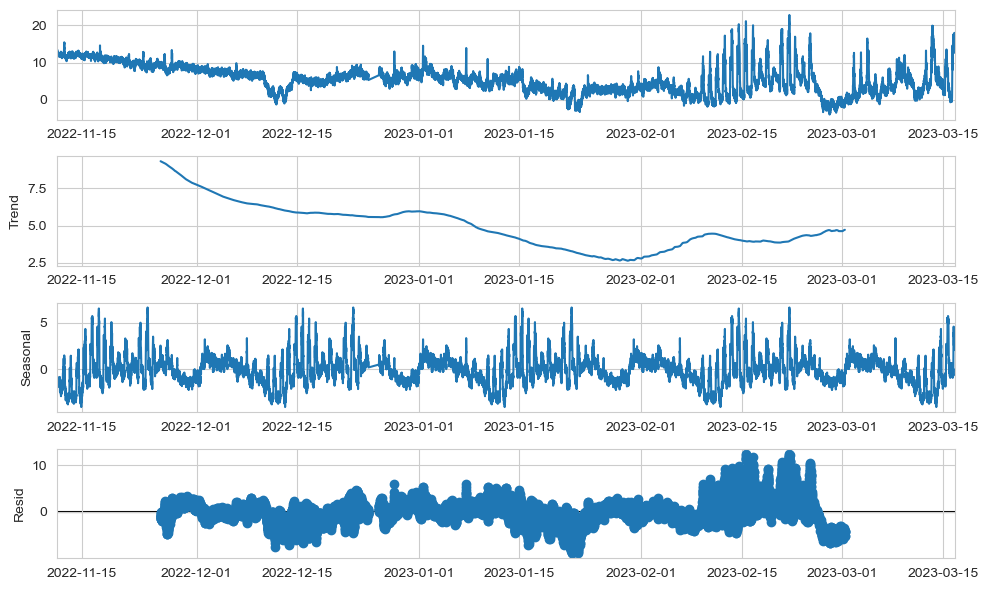

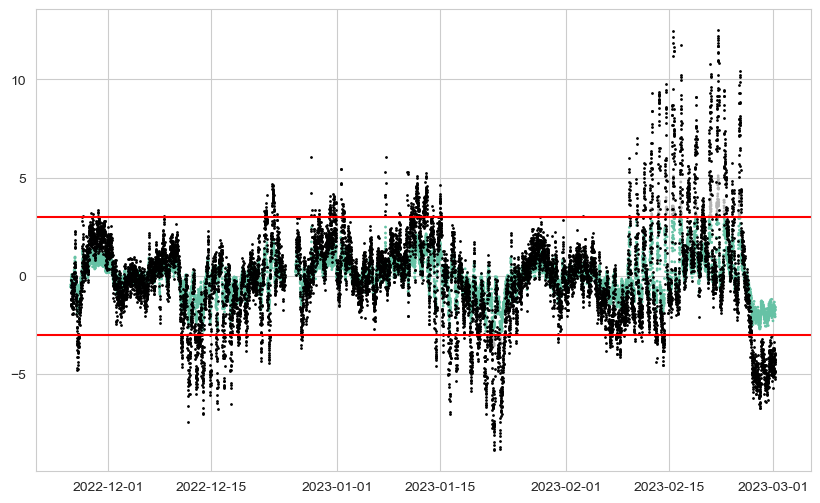

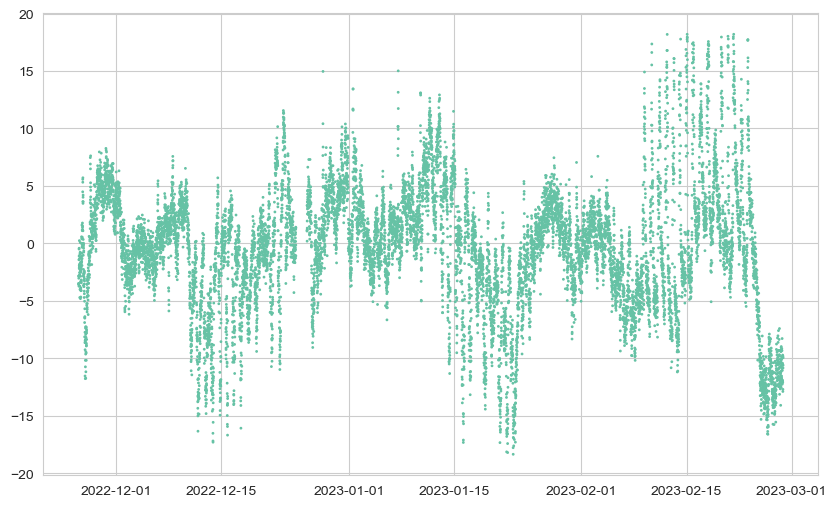

,index,resid,is_outlier
datetime,,,
2022-11-25 23:50:12.659,0.0,-3.582721,0.0
2022-11-26 00:00:12.724,1.0,-3.487501,0.0
2022-11-26 00:10:12.697,2.0,-2.867538,0.0
2022-11-26 00:20:12.645,3.0,-3.525074,0.0
2022-11-26 00:30:12.645,4.0,-3.040822,0.0
2022-11-26 00:40:12.549,5.0,-2.828197,0.0
2022-11-26 00:50:12.619,6.0,-1.430231,0.0
2022-11-26 01:00:12.617,7.0,-3.735339,0.0
2022-11-26 01:10:12.567,8.0,-2.830793,0.0


In [91]:
print(LakeAegeri.dataframe.columns)
LakeAegeri.detect_outlier2("y",PERIOD=288*14) #288 is 1 day in Aegeri(Outliers.loc['2022-12-02':'2022-12-03'])

In [92]:
#LakeAegeri.AutoRegressiveModel(column="y")

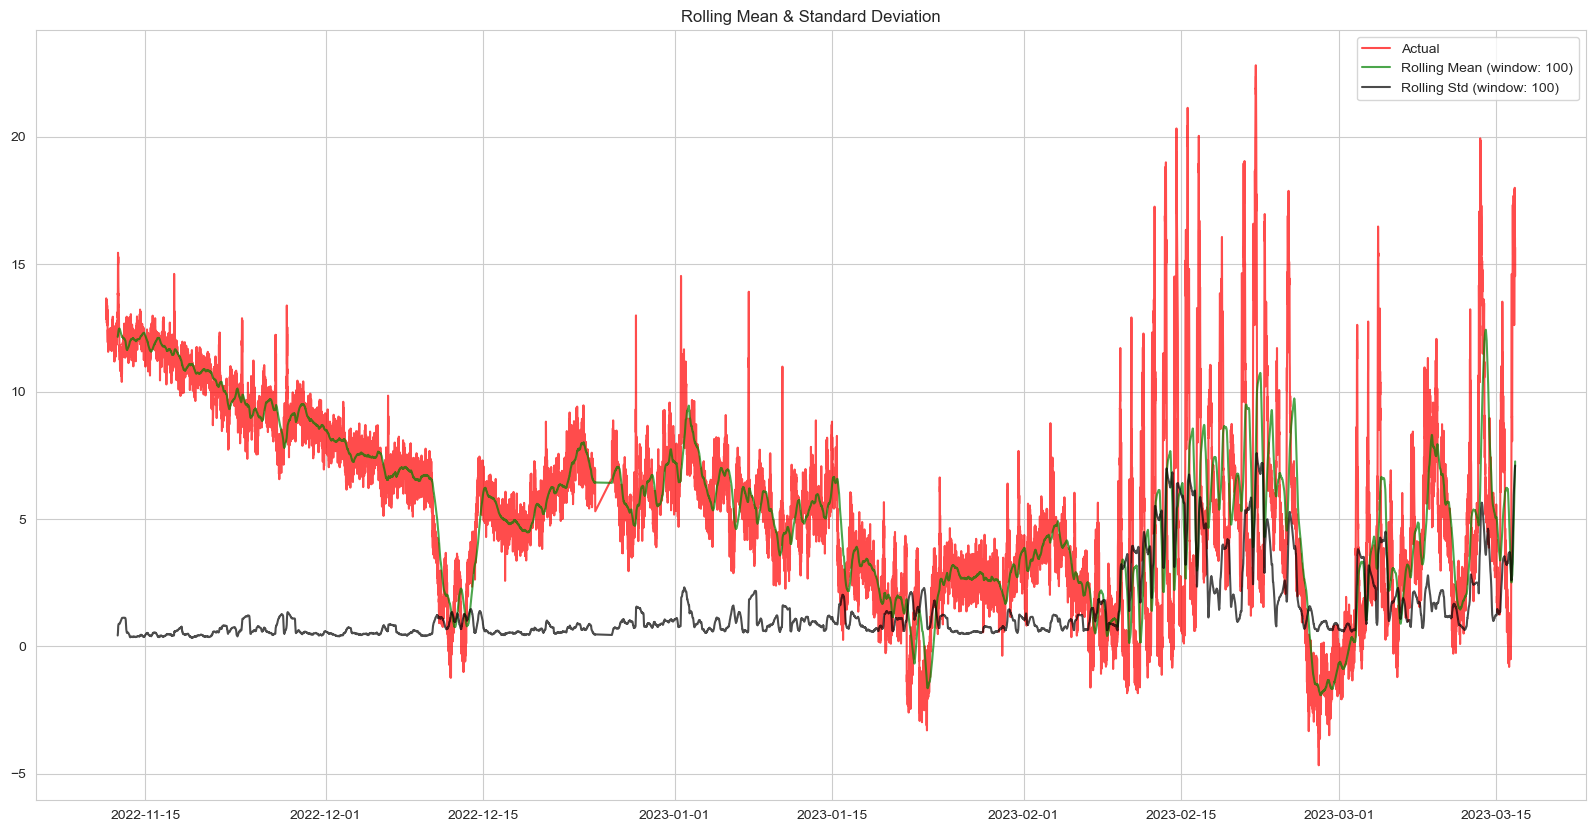

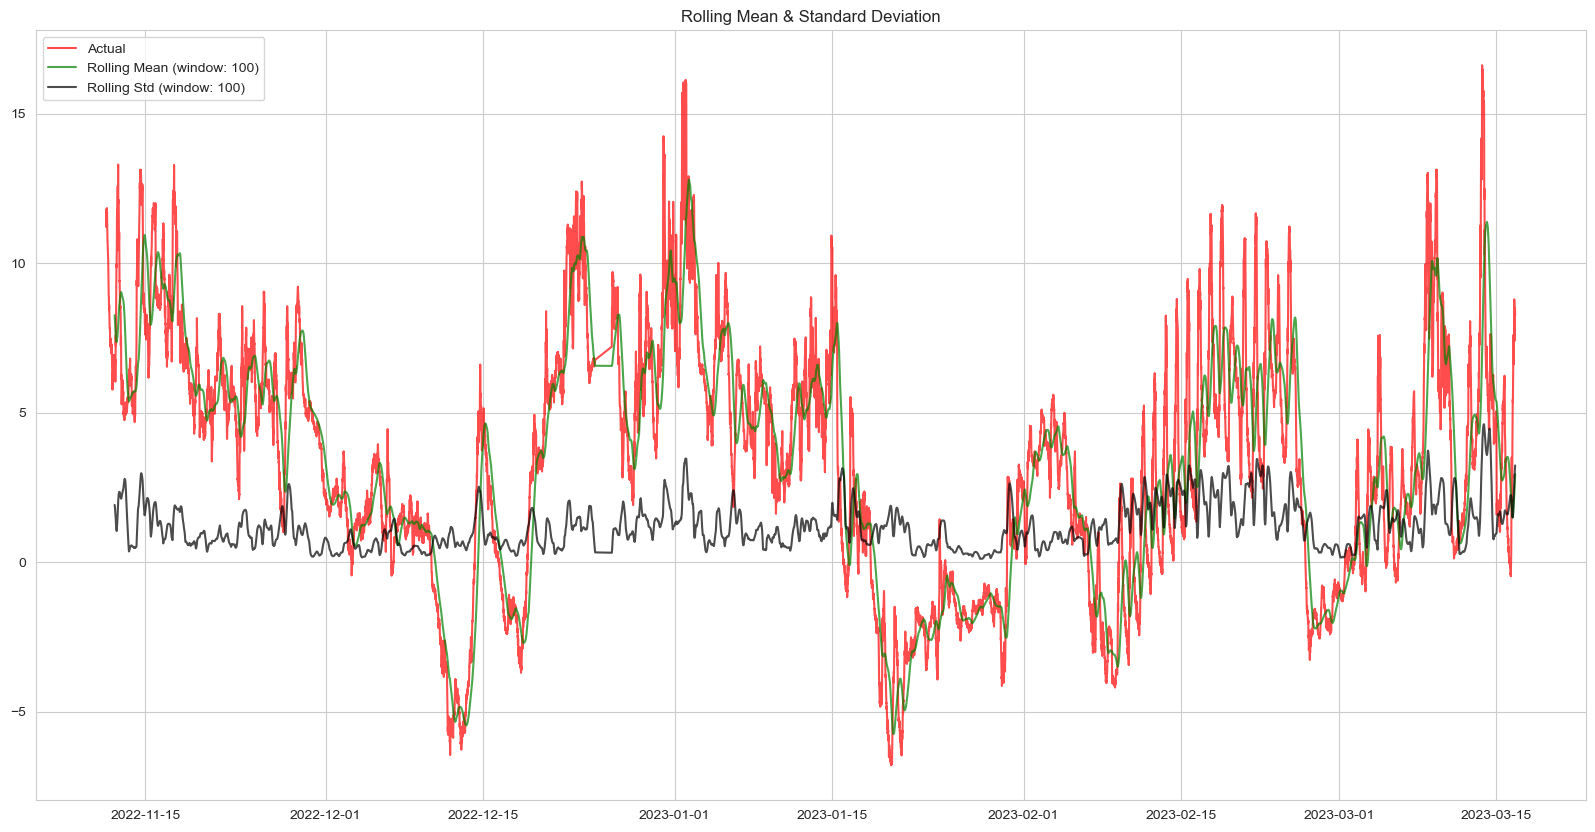

In [93]:
LakeAegeri.calc_rolling_statistics(window=100,column="y",statistics="mean",plot="no",save_plot="rolling_mean")
LakeAegeri.calc_rolling_statistics(window=100,column="air_temp",statistics="mean",plot="no")

In [94]:
LakeAegeri.check_stationarity(column="y")

Visual check is advised with LakeAegeri.calc_rolling_statsitics(...,plot='Y')
->  A stationary Time Series is one which characteristics like mean and variance does not change over time.
Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:
--------------------
Dickey-Fuller Test: 
with a p-value of 0.0, we reject the null hypothesis, that the data is stationary.
Test Statistic         -9.994078e+00
p-value                 1.961180e-17
Lags Used               2.600000e+01
No. of Obs              1.763300e+04
Critical Value (1%)    -3.430721e+00
Critical Value (5%)    -2.861704e+00
Critical Value (10%)   -2.566857e+00
dtype: float64


True